In [3]:
log_data = """2024-12-18 10:15:32 INFO User logged in
2024-12-18 10:16:02 ERROR Page not found
2024-12-18 10:17:20 INFO Data uploaded successfully
2024-12-18 11:00:01 ERROR Service unavailable
2024-12-18 11:15:10 INFO Backup completed
2024-12-18 12:25:30 INFO User logged out"""

with open('logfile.txt', 'w') as f:
    f.write(log_data)


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Log Analysis").getOrCreate()

log_df = spark.read.text("logfile.txt")
log_df.show(truncate=False)


+---------------------------------------------------+
|value                                              |
+---------------------------------------------------+
|2024-12-18 10:15:32 INFO User logged in            |
|2024-12-18 10:16:02 ERROR Page not found           |
|2024-12-18 10:17:20 INFO Data uploaded successfully|
|2024-12-18 11:00:01 ERROR Service unavailable      |
|2024-12-18 11:15:10 INFO Backup completed          |
|2024-12-18 12:25:30 INFO User logged out           |
+---------------------------------------------------+



In [4]:
from pyspark.sql.functions import regexp_extract
log_df = log_df.withColumn("timestamp", regexp_extract("value", r'^([\d-]+\s[\d:]+)', 1)) \
               .withColumn("log_level", regexp_extract("value", r'\s(INFO|ERROR|DEBUG|WARN)\s', 1)) \
               .withColumn("message", regexp_extract("value", r'\s(INFO|ERROR|DEBUG|WARN)\s(.+)', 2))

log_df.select("timestamp", "log_level", "message").show(truncate=False)


+-------------------+---------+--------------------------+
|timestamp          |log_level|message                   |
+-------------------+---------+--------------------------+
|2024-12-18 10:15:32|INFO     |User logged in            |
|2024-12-18 10:16:02|ERROR    |Page not found            |
|2024-12-18 10:17:20|INFO     |Data uploaded successfully|
|2024-12-18 11:00:01|ERROR    |Service unavailable       |
|2024-12-18 11:15:10|INFO     |Backup completed          |
|2024-12-18 12:25:30|INFO     |User logged out           |
+-------------------+---------+--------------------------+



In [5]:
log_level_count = log_df.groupBy("log_level").count()
log_level_count.show()


+---------+-----+
|log_level|count|
+---------+-----+
|     INFO|    4|
|    ERROR|    2|
+---------+-----+



In [6]:
error_logs = log_df.filter(log_df.log_level == "ERROR")
error_logs.show(truncate=False)


+---------------------------------------------+-------------------+---------+-------------------+
|value                                        |timestamp          |log_level|message            |
+---------------------------------------------+-------------------+---------+-------------------+
|2024-12-18 10:16:02 ERROR Page not found     |2024-12-18 10:16:02|ERROR    |Page not found     |
|2024-12-18 11:00:01 ERROR Service unavailable|2024-12-18 11:00:01|ERROR    |Service unavailable|
+---------------------------------------------+-------------------+---------+-------------------+



In [7]:
from pyspark.sql.functions import hour

hourly_logs = log_df.withColumn("hour", hour("timestamp")) \
                    .groupBy("hour").count()

hourly_logs.show()


+----+-----+
|hour|count|
+----+-----+
|  12|    1|
|  10|    3|
|  11|    2|
+----+-----+



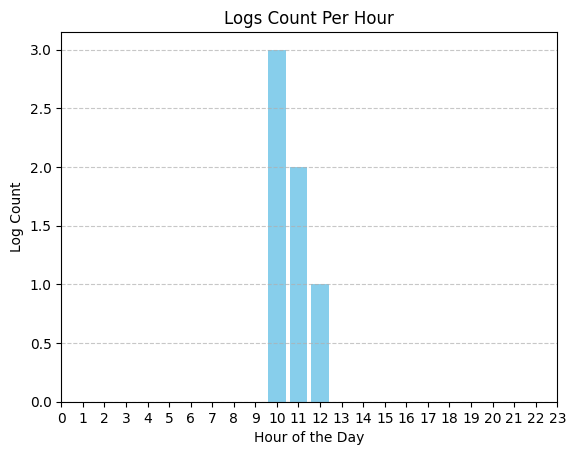

In [8]:
import matplotlib.pyplot as plt

hourly_data = hourly_logs.collect()
hours = [row['hour'] for row in hourly_data]
counts = [row['count'] for row in hourly_data]

plt.bar(hours, counts, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Log Count')
plt.title('Logs Count Per Hour')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
